## PyTorch Basics

### Getting Started

Welcome! This notebook will be an introduction to PyTorch. We will implement a simple 2-layer neural network that will solve a classification task using cross entropy loss. We will start with a naive NumPy implementation, **numpy_version**, where we explicitly define the forward and backward passes. This will allow us to understand the math behind the network and also see the explicit matrix operations that PyTorch will abstract and simplify. 

After the NumPy implementation, we will slowly start replacing sections of code with PyTorch components in **pytorch_tensors**. We will start with replacing NumPy arrays with PyTorch tensors. This section will also cover some of the matrix operations and manipulations. Next in **pytorch_autograd**, we will use autograd variables in order to have automatic backpropgation of the loss through our weights and biases. Next in **pytorch_custom_autograd**, we will learn how to implement our own custom autograd variables by explicitly defining the forward and backward pass. Then, we will jump to defining full models using nn.Modules in **pytorch_nn**. Then, to simplify even further, we will replace the parameter updates with an optimizer in **pytorch_optimization**. In the last function, **pytorch_cuda**, we will enable training with GPU (if present).

### Requirements

In [27]:
# Call packages
from __future__ import (
    print_function,
)

__author__ = "Goku Mohandas"
__email__ = "gokumd@gmail.com"

import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import (
    datasets,
    transforms,
)

from torch.autograd import (
    Variable,
)

### Arguments

In [42]:
class get_args():
    """
    Arguments.
    """
    def __init__(self):
        """
        """
        self.seed = 1234
        self.num_samples = 200
        self.dimensions = 2
        self.num_classes = 3
        self.num_hidden_units = 100
        self.regularization = 1e-3
        self.learning_rate = 1.0
        self.num_epochs = 2500
        self.no_cuda = False

In [74]:
FLAGS = get_args()

# CUDA
FLAGS.cuda = not FLAGS.no_cuda and torch.cuda.is_available()

# Seeding
torch.manual_seed(FLAGS.seed)
if FLAGS.cuda:
    torch.cuda.manual_seed_all(FLAGS.seed)

### Data

In [51]:
def get_data(seed, num_samples, dimensions, num_classes):
    """
    Create input data.
    """
    np.random.seed (seed)
    N = num_samples
    D = dimensions
    C = num_classes

    # Create spiral data
    X = np.zeros ((N*C, D))
    y = np.zeros (N*C, dtype='int_')
    for j in xrange (C):
        ix = range (N*j,N*(j+1))
        r = np.linspace (0.0,1,N)
        t = np.linspace (j*4,(j+1)*4,N) + np.random.randn (N)*0.1
        X[ix] = np.c_[r*np.sin (t), r*np.cos (t)]
        y[ix] = j

    print ("X:", (np.shape (X)))
    print ("y:", (np.shape (y)))

    return X, y

In [52]:
def plot_data(X, y):
    """
    Plot the data.
    """
    plt.scatter (X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show ()

X: (600, 2)
y: (600,)


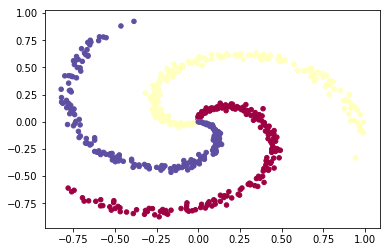

In [54]:
# Create the data
X, y = get_data (FLAGS.seed, FLAGS.num_samples, FLAGS.dimensions,
    FLAGS.num_classes)
plot_data(X, y)

In [56]:
def plot_model(X, y, w1, b1, w2, b2):
    """
    Plot the model solution space.
    """
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

### Math

### Numpy

In [57]:
def numpy_version(X, y, num_hidden_units, num_classes, regularization,
    learning_rate, num_epochs):
    """
    Implement NN with numpy.
    """

    # Dimensions
    N = len(X) # num. samples
    D_in = len(X[0]) # input dim.
    H = num_hidden_units # hidden dim.
    D_out = num_classes # output dim.

    # Weights
    w1 = 0.01 * np.random.randn(D_in, H)
    w2 = 0.01 * np.random.randn(H, D_out)
    b1 = np.zeros((1, H))
    b2 = np.zeros((1, D_out))

    for epoch in range(num_epochs):

        # Forward pass
        h = np.dot(X, w1) + b1
        h_relu = np.maximum(0, h)
        scores = np.dot(h_relu, w2) + b2
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N, D_out]

        # Cross entropy loss
        y_true_logprobs = -np.log(probs[range(N), y])
        loss = np.sum(y_true_logprobs) / N
        loss += 0.5*regularization*np.sum(w1*w1) + 0.5*regularization*np.sum(w2*w2)

        # Backpropagation
        dJ__dscores = probs
        dJ__dscores[range(N), y] -= 1
        dJ__dscores /= N

        dJ__dw2 = np.dot(h_relu.T, dJ__dscores)
        dJ__db2 = np.sum(dJ__dscores, axis=0, keepdims=True)
        dJ__dh_relu = np.dot(dJ__dscores, w2.T)
        dJ__dh_relu[h_relu <= 0] = 0 # dJ__dh
        dJ__dh = dJ__dh_relu
        dJ__dw1 = np.dot(X.T, dJ__dh)
        dJ__db1 = np.sum(dJ__dh, axis=0, keepdims=True)

        # Derivative of regularization component
        dJ__dw2 += regularization * w2
        dJ__dw1 += regularization * w1

        # Gradient descent
        w1 -= learning_rate * dJ__dw1
        b1 -= learning_rate * dJ__db1
        w2 -= learning_rate * dJ__dw2
        b2 += -learning_rate * dJ__db2

        # Verbose
        if (epoch == 0) or (epoch % 1000 == 0) or (epoch == num_epochs-1):

            # Accuracy
            y_pred = np.argmax(scores, axis=1)
            train_accuracy = (np.mean(y_pred == y))

            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f" %
                (epoch, loss, train_accuracy))

    # Plot trained model
    plot_model(X, y, w1, b1, w2, b2)

[EPOCH]: 0, [TRAIN LOSS]: 1.098556, [TRAIN ACC]: 0.475
[EPOCH]: 1000, [TRAIN LOSS]: 0.273884, [TRAIN ACC]: 0.928
[EPOCH]: 2000, [TRAIN LOSS]: 0.255643, [TRAIN ACC]: 0.972
[EPOCH]: 2499, [TRAIN LOSS]: 0.248129, [TRAIN ACC]: 0.972


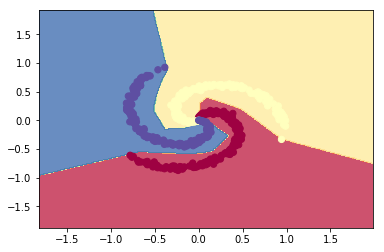

In [58]:
# Numpy
numpy_version(X, y, FLAGS.num_hidden_units, FLAGS.num_classes,
              FLAGS.regularization, FLAGS.learning_rate, FLAGS.num_epochs)

### PyTorch Tensors

In [59]:
def pytorch_tensors(X, y, num_hidden_units, num_classes, regularization,
    learning_rate, num_epochs, dtype=torch.FloatTensor):
    """
    Implement NN with PyTorch tensors.
    """

    # Dimensions
    N = len(X) # num. samples
    D_in = len(X[0]) # input dim.
    H = num_hidden_units # hidden dim.
    D_out = num_classes # output dim.

    # Convert data to PyTorch tensors
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)

    # Weights
    w1 = torch.randn(D_in, H).type(dtype)
    w2 = torch.randn(H, D_out).type(dtype)
    b1 = torch.zeros((1, H))
    b2 = torch.zeros((1, D_out))

    for epoch in range(num_epochs):

        # Forward pass
        h = X.mm(w1) + b1.repeat(N,1)
        h_relu = h.clamp(min=0)
        scores = h_relu.mm(w2) + b2.repeat(N,1)
        exp_scores = torch.exp(scores)

        probs = exp_scores / torch.sum(exp_scores, dim=1).repeat(1,num_classes) # [N, D_out]

        # Cross entropy loss
        y_true_logprobs = -torch.log(torch.gather(probs, 1, y.unsqueeze(1)))
        loss = torch.sum(y_true_logprobs) / float(N)
        loss += 0.5*regularization*torch.sum(w1*w1) + 0.5*regularization*torch.sum(w2*w2)

        # Backpropagation
        dJ__dscores = probs

        def bp_correct_class(i, row, correct_class):
            """
            1-prob for the correct class for sample i.
            """
            row[correct_class] = row[correct_class] - 1
            return row

        for i, row in enumerate(dJ__dscores):
            dJ__dscores[i] = bp_correct_class(i, row, y[i])

        dJ__dscores /= float(N)

        dJ__dw2 = torch.transpose(h_relu, 0, 1).mm(dJ__dscores)
        dJ__db2 = torch.sum(dJ__dscores, dim=0)
        dJ__dh_relu = dJ__dscores.mm(torch.transpose(w2, 0, 1))
        dJ__dh_relu[h_relu <= 0] = 0 # dJ__dh
        dJ__dh = dJ__dh_relu
        dJ__dw1 = torch.transpose(X, 0, 1).mm(dJ__dh)
        dJ__db1 = torch.sum(dJ__dh, dim=0)

        # Derivative of regularization component
        dJ__dw2 += regularization * w2
        dJ__dw1 += regularization * w1

        # Gradient descent
        w1 -= learning_rate * dJ__dw1
        b1 -= learning_rate * dJ__db1
        w2 -= learning_rate * dJ__dw2
        b2 += -learning_rate * dJ__db2

        # Verbose
        if (epoch == 0) or (epoch % 1000 == 0) or (epoch == num_epochs-1):

            # Accuracy
            score, predicted = torch.max(scores, 1)
            train_accuracy = (y == predicted).sum() / float(N)

            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f" %
                (epoch, loss, train_accuracy))

    # Plot trained model
    plot_model(X.numpy(), y.numpy(), w1.numpy(), b1.numpy(), w2.numpy(), b2.numpy())

[EPOCH]: 0, [TRAIN LOSS]: 2.471428, [TRAIN ACC]: 0.330
[EPOCH]: 1000, [TRAIN LOSS]: 0.244884, [TRAIN ACC]: 0.993
[EPOCH]: 2000, [TRAIN LOSS]: 0.232903, [TRAIN ACC]: 0.995
[EPOCH]: 2499, [TRAIN LOSS]: 0.231558, [TRAIN ACC]: 0.995


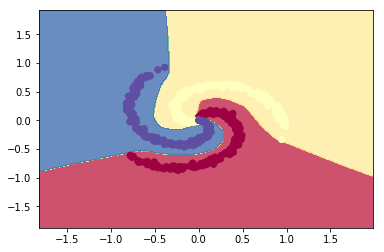

In [60]:
# PyTorch tensors (no autograd, opti, etc.)
pytorch_tensors(X, y, FLAGS.num_hidden_units, FLAGS.num_classes,
                FLAGS.regularization, FLAGS.learning_rate, FLAGS.num_epochs)

### PyTorch Autograd

In [62]:
def pytorch_autograd(X, y, num_hidden_units, num_classes, regularization,
    learning_rate, num_epochs, dtype=torch.FloatTensor):
    """
    Use autograd variables for
    implicit backprop.
    """

    # Dimensions
    N = len(X) # num. samples
    D_in = len(X[0]) # input dim.
    H = num_hidden_units # hidden dim.
    D_out = num_classes # output dim.

    # Convert data to PyTorch tensors
    X = Variable(torch.FloatTensor(X), requires_grad=False)
    y = Variable(torch.LongTensor(y), requires_grad=False)

    # Weights
    w1 = Variable(torch.randn(D_in, H).type(dtype), requires_grad=True)
    w2 = Variable(torch.randn(H, D_out).type(dtype), requires_grad=True)
    b1 = Variable(torch.zeros((1, H)), requires_grad=True)
    b2 = Variable(torch.zeros((1, D_out)), requires_grad=True)

    for epoch in range(num_epochs):

        # Forward pass
        h = X.mm(w1) + b1.repeat(N,1)
        h_relu = h.clamp(min=0)
        scores = h_relu.mm(w2) + b2.repeat(N,1)
        exp_scores = torch.exp(scores)

        # Softmax normalization
        probs = exp_scores / torch.sum(exp_scores, dim=1).repeat(1,num_classes) # [N, D_out]

        # Cross entropy loss
        y_true_logprobs = -torch.log(torch.gather(probs, 1, y.unsqueeze(1)))
        loss = torch.sum(y_true_logprobs) / float(N)

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        loss.backward()

        # Update the weights
        w1.data -= learning_rate * w1.grad.data
        w2.data -= learning_rate * w2.grad.data
        b1.data -= learning_rate * b1.grad.data
        b2.data -= learning_rate * b2.grad.data

        # Zero-out the gradients before backprop
        w1.grad.data.zero_()
        w2.grad.data.zero_()
        b1.grad.data.zero_()
        b2.grad.data.zero_()

        # Verbose
        if (epoch == 0) or (epoch % 1000 == 0) or (epoch == num_epochs-1):

            # Accuracy
            score, predicted = torch.max(scores, 1)
            train_accuracy = (y.data == predicted.data).sum() / float(N)

            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f" %
                (epoch, loss.data[0], train_accuracy))

    # Plot trained model
    plot_model(X.data.numpy(), y.data.numpy(), w1.data.numpy(), b1.data.numpy(),
        w2.data.numpy(), b2.data.numpy())

[EPOCH]: 0, [TRAIN LOSS]: 4.378161, [TRAIN ACC]: 0.228
[EPOCH]: 1000, [TRAIN LOSS]: 0.037196, [TRAIN ACC]: 0.997
[EPOCH]: 2000, [TRAIN LOSS]: 0.027039, [TRAIN ACC]: 0.997
[EPOCH]: 2499, [TRAIN LOSS]: 0.024486, [TRAIN ACC]: 0.997


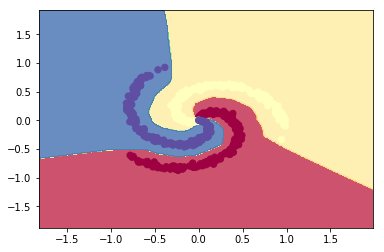

In [63]:
# PyTorch autograd
pytorch_autograd(X, y, FLAGS.num_hidden_units, FLAGS.num_classes,
                 FLAGS.regularization, FLAGS.learning_rate, FLAGS.num_epochs)

### PyTorch Custom Autograd

In [64]:
def pytorch_custom_autograd(X, y, num_hidden_units, num_classes, regularization,
    learning_rate, num_epochs, dtype=torch.FloatTensor):
    """
    Use autograd variables for
    implicit backprop and
    make your own autograd func.
    """

    class ReLU(torch.autograd.Function):
        """
        Just implemnet forward and
        backward pass.
        """

        def forward(self, input_):
            """
            Process inputs and use
            save_for_backward to store
            inputs for backprop.
            """
            self.save_for_backward(input_)
            return input_.clamp(min=0)

        def backward(self, grad_output):
            """
            grad_output is the grad w.r.t loss.
            """
            input_, =self.saved_tensors
            grad_input = grad_output.clone()
            grad_input[input_ < 0] = 0
            return grad_input

    # Dimensions
    N = len(X) # num. samples
    D_in = len(X[0]) # input dim.
    H = num_hidden_units # hidden dim.
    D_out = num_classes # output dim.

    # Convert data to PyTorch tensors
    X = Variable(torch.FloatTensor(X), requires_grad=False)
    y = Variable(torch.LongTensor(y), requires_grad=False)

    # Weights
    w1 = Variable(torch.randn(D_in, H).type(dtype), requires_grad=True)
    w2 = Variable(torch.randn(H, D_out).type(dtype), requires_grad=True)
    b1 = Variable(torch.zeros((1, H)), requires_grad=True)
    b2 = Variable(torch.zeros((1, D_out)), requires_grad=True)

    for epoch in range(num_epochs):

        # custom autograd func.
        relu = ReLU()

        # Forward pass
        h = X.mm(w1) + b1.repeat(N,1)
        h_relu = relu(h)
        scores = h_relu.mm(w2) + b2.repeat(N,1)
        exp_scores = torch.exp(scores)

        # Softmax normalization
        probs = exp_scores / torch.sum(exp_scores, dim=1).repeat(1,num_classes) # [N, D_out]

        # Cross entropy loss
        y_true_logprobs = -torch.log(torch.gather(probs, 1, y.unsqueeze(1)))
        loss = torch.sum(y_true_logprobs) / float(N)

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        loss.backward()

        # Update the weights
        w1.data -= learning_rate * w1.grad.data
        w2.data -= learning_rate * w2.grad.data
        b1.data -= learning_rate * b1.grad.data
        b2.data -= learning_rate * b2.grad.data

        # Zero-out the gradients before backprop
        w1.grad.data.zero_()
        w2.grad.data.zero_()
        b1.grad.data.zero_()
        b2.grad.data.zero_()

        # Verbose
        if (epoch == 0) or (epoch % 1000 == 0) or (epoch == num_epochs-1):

            # Accuracy
            score, predicted = torch.max(scores, 1)
            train_accuracy = (y.data == predicted.data).sum() / float(N)

            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f" %
                (epoch, loss.data[0], train_accuracy))

    # Plot trained model
    plot_model(X.data.numpy(), y.data.numpy(), w1.data.numpy(), b1.data.numpy(),
        w2.data.numpy(), b2.data.numpy())

[EPOCH]: 0, [TRAIN LOSS]: 2.779339, [TRAIN ACC]: 0.415
[EPOCH]: 1000, [TRAIN LOSS]: 0.036736, [TRAIN ACC]: 0.997
[EPOCH]: 2000, [TRAIN LOSS]: 0.026987, [TRAIN ACC]: 0.997
[EPOCH]: 2499, [TRAIN LOSS]: 0.024487, [TRAIN ACC]: 0.997


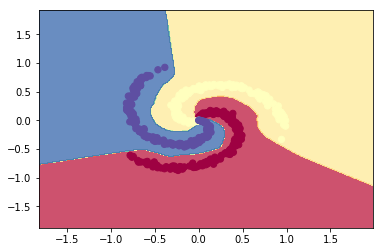

In [65]:
# PyTorch custom autograd
pytorch_custom_autograd(X, y, FLAGS.num_hidden_units, FLAGS.num_classes,
                        FLAGS.regularization, FLAGS.learning_rate, FLAGS.num_epochs)

### PyTorch nn.Module

In [66]:
def pytorch_nn(X, y, num_hidden_units, num_classes, regularization,
    learning_rate, num_epochs, dtype=torch.FloatTensor):
    """
    Use nn.Module.
    """

    # Dimensions
    N = len(X) # num. samples
    D_in = len(X[0]) # input dim.
    H = num_hidden_units # hidden dim.
    D_out = num_classes # output dim.

    # Convert data to PyTorch tensors
    X = Variable(torch.FloatTensor(X), requires_grad=False)
    y = Variable(torch.LongTensor(y), requires_grad=False)

    # Model
    class Model(nn.Module):
        """
        NN model using nn.Module
        """
        def __init__(self):
            """
            Initialize weights.
            """
            super(Model, self).__init__()
            self.fc1 = nn.Linear(D_in, H)
            self.fc2 = nn.Linear(H, D_out)

        def forward(self, x):
            """
            Forward pass.
            """
            z = F.relu(self.fc1(x))
            z = self.fc2(z)
            return z

    # Create model
    model = Model()

    # Objective
    criterion = torch.nn.CrossEntropyLoss()

    # Training
    for epoch in range(num_epochs):

        # Zero-out gradients
        model.zero_grad()

        # Forward pass
        scores = model(X) # logits

        # Loss
        loss = criterion(scores, y)

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        loss.backward()

        # Update the weights
        for param in model.parameters():
            param.data -= learning_rate * param.grad.data

        # Verbose
        if (epoch == 0) or (epoch % 1000 == 0) or (epoch == num_epochs-1):

            # Accuracy
            score, predicted = torch.max(scores, 1)
            train_accuracy = (y.data == predicted.data).sum() / float(N)

            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f" %
                (epoch, loss.data[0], train_accuracy))

    # Plot trained model
    plot_model(X.data.numpy(), y.data.numpy(),
        torch.transpose(model.fc1.weight.data, 0, 1).numpy(),
        model.fc1.bias.data.numpy(),
        torch.transpose(model.fc2.weight.data, 0, 1).numpy(),
        model.fc2.bias.data.numpy())

[EPOCH]: 0, [TRAIN LOSS]: 1.065537, [TRAIN ACC]: 0.333
[EPOCH]: 1000, [TRAIN LOSS]: 0.054344, [TRAIN ACC]: 0.993
[EPOCH]: 2000, [TRAIN LOSS]: 0.033581, [TRAIN ACC]: 0.997
[EPOCH]: 2499, [TRAIN LOSS]: 0.029331, [TRAIN ACC]: 0.997


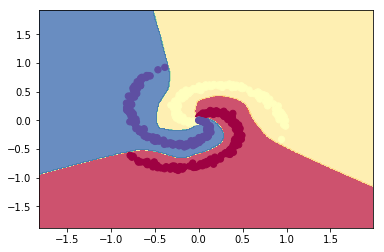

In [67]:
# Pytorch nn.Module
pytorch_nn(X, y, FLAGS.num_hidden_units, FLAGS.num_classes,
           FLAGS.regularization, FLAGS.learning_rate, FLAGS.num_epochs)

### PyTorch Optimization

In [73]:
def pytorch_optimization(X, y, num_hidden_units, num_classes, regularization,
    learning_rate, num_epochs, dtype=torch.FloatTensor):
    """
    Putting it all together
    with the optimization tools.
    """

    # Dimensions
    N = len(X) # num. samples
    D_in = len(X[0]) # input dim.
    H = num_hidden_units # hidden dim.
    D_out = num_classes # output dim.

    # Convert data to PyTorch tensors
    X = Variable(torch.FloatTensor(X), requires_grad=False)
    y = Variable(torch.LongTensor(y), requires_grad=False)

    # Model
    class Model(nn.Module):
        """
        NN model using nn.Module
        """
        def __init__(self):
            """
            Initialize weights.
            """
            super(Model, self).__init__()
            self.fc1 = nn.Linear(D_in, H)
            self.fc2 = nn.Linear(H, D_out)

        def forward(self, x):
            """
            Forward pass.
            """
            z = F.relu(self.fc1(x))
            z = self.fc2(z)
            return z

    # Create model
    model = Model()

    # Objective
    criterion = torch.nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    for epoch in range(num_epochs):

        # Forward pass
        scores = model(X) # logits

        # Loss
        loss = criterion(scores, y)

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Verbose
        if (epoch == 0) or (epoch % 1000 == 0) or (epoch == num_epochs-1):

            # Accuracy
            score, predicted = torch.max(scores, 1)
            train_accuracy = (y.data == predicted.data).sum() / float(N)

            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f" %
                (epoch, loss.data[0], train_accuracy))

    # Plot trained model
    plot_model(X.data.numpy(), y.data.numpy(),
        torch.transpose(model.fc1.weight.data, 0, 1).numpy(),
        model.fc1.bias.data.numpy(),
        torch.transpose(model.fc2.weight.data, 0, 1).numpy(),
        model.fc2.bias.data.numpy())

[EPOCH]: 0, [TRAIN LOSS]: 1.176377, [TRAIN ACC]: 0.255
[EPOCH]: 1000, [TRAIN LOSS]: 0.007297, [TRAIN ACC]: 0.997
[EPOCH]: 2000, [TRAIN LOSS]: 0.006389, [TRAIN ACC]: 0.997
[EPOCH]: 2499, [TRAIN LOSS]: 0.006191, [TRAIN ACC]: 0.997


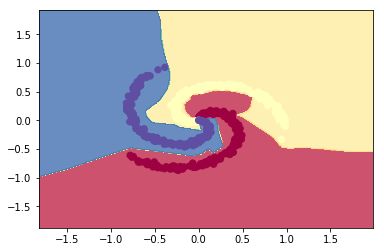

In [75]:
# PyTorch optim
pytorch_optimization(X, y, FLAGS.num_hidden_units, FLAGS.num_classes,
                     FLAGS.regularization, FLAGS.learning_rate, FLAGS.num_epochs)

### PyTorch CUDA

In [78]:
FLAGS.cuda = True
FLAGS.cuda = not FLAGS.no_cuda and torch.cuda.is_available()

In [79]:
def pytorch_cuda(X, y, num_hidden_units, num_classes, regularization,
    learning_rate, num_epochs, cuda_enabled):
    """
    CUDA enabled.
    """

    # dtype
    if not cuda_enabled:
        dtype = torch.FloatTensor
        print ("Not using GPU :(")
    else:
        dtype = torch.cuda.FloatTensor
        print ("Using GPU :)")

    # Convert data to PyTorch tensors
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)
    if cuda_enabled:
        X = X.cuda()
        y = y.cuda()
    X = Variable(X, requires_grad=False)
    y = Variable(y, requires_grad=False)

    # Dimensions
    N = len(X) # num. samples
    D_in = len(X[0]) # input dim.
    H = num_hidden_units # hidden dim.
    D_out = num_classes # output dim.

    # Model
    class Model(nn.Module):
        """
        NN model using nn.Module
        """
        def __init__(self):
            """
            Initialize weights.
            """
            super(Model, self).__init__()
            self.fc1 = nn.Linear(D_in, H)
            self.fc2 = nn.Linear(H, D_out)

        def forward(self, x):
            """
            Forward pass.
            """
            z = F.relu(self.fc1(x))
            z = self.fc2(z)
            return z

    # Create model
    model = Model()
    if cuda_enabled:
        model.cuda()

    # Objective
    criterion = torch.nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    for epoch in range(num_epochs):

        # Forward pass
        scores = model(X) # logits

        # Loss
        loss = criterion(scores, y)

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Verbose
        if (epoch == 0) or (epoch % 1000 == 0) or (epoch == num_epochs-1):

            # Accuracy
            score, predicted = torch.max(scores, 1)
            train_accuracy = (y.data == predicted.data).cpu().sum() / float(N)

            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f" %
                (epoch, loss.data[0], train_accuracy))

    # Plot trained model
    plot_model(X.data.numpy(), y.data.numpy(),
        torch.transpose(model.fc1.weight.data, 0, 1).numpy(),
        model.fc1.bias.data.numpy(),
        torch.transpose(model.fc2.weight.data, 0, 1).numpy(),
        model.fc2.bias.data.numpy())

Not using GPU :(
[EPOCH]: 0, [TRAIN LOSS]: 1.143009, [TRAIN ACC]: 0.333
[EPOCH]: 1000, [TRAIN LOSS]: 0.008315, [TRAIN ACC]: 0.997
[EPOCH]: 2000, [TRAIN LOSS]: 0.006300, [TRAIN ACC]: 0.997
[EPOCH]: 2499, [TRAIN LOSS]: 0.005976, [TRAIN ACC]: 0.997


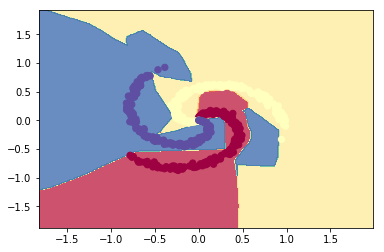

In [80]:
pytorch_cuda(X, y, FLAGS.num_hidden_units, FLAGS.num_classes,
             FLAGS.regularization, FLAGS.learning_rate, FLAGS.num_epochs,
             cuda_enabled=FLAGS.cuda)

### Next Steps